# MinD Oscillations in E. coli

One spatial reaction-diffusion system that has been studied frequently in the literature both in a deterministic setting (Huang et. al, 2003) and using a stochastic description (Fange and Elf, 2006) is describing the periodic oscillations of Min proteins in the bacterium E. Coli. By oscillating from pole to pole, MinC suppresses the formation of a cell division site at the poles, indirectly positioning it in the middle of the cell.

References:
 - Kerwyn Casey Huang, Yigal Meir, and Ned S. Wingreen, Dynamic structures in Escherichia coli: Spontaneous formation of MinE rings and MinD polar zones,PNAS, 2003.
 - David Fange and Johan Elf, Noise-induced Min Phenotypes in E. Coli, PLOS Computational Biology, 2(6), 2006.

### Imports and definitions

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append('../..')

import numpy as np
import matplotlib.pyplot as plt

import spatialpy

In [2]:
class Membrane(spatialpy.Geometry):
    def inside(self, x, on_boundary):
        return on_boundary


class Cytosol(spatialpy.Geometry):
    def inside(self, x, on_boundary):
        return not on_boundary

### Model

In [3]:
class mincde(spatialpy.Model):
    """ Model of MinD oscillations in E. Coli, based on the model by Huang. et. al. in """

    def __init__(self,model_name="mincde"):
        spatialpy.Model.__init__(self, model_name)

        # Species
        MinD_m = spatialpy.Species(name="MinD_m", diffusion_constant=1e-14)
        MinD_c_atp = spatialpy.Species(name="MinD_c_atp", diffusion_constant=2.5e-12)
        MinD_c_adp = spatialpy.Species(name="MinD_c_adp", diffusion_constant=2.5e-12)
        MinD_e = spatialpy.Species(name="MinD_e", diffusion_constant=2.5e-12)
        MinDE = spatialpy.Species(name="MinDE", diffusion_constant=1e-14)
        self.add_species([MinD_m, MinD_c_atp, MinD_c_adp, MinD_e, MinDE])
        
        # Restrict to membrane
        self.restrict(MinD_m, 2)
        self.restrict(MinDE, 2)
        
        # Domain
        self.domain = spatialpy.Domain.read_msh_file("mesh/coli.msh")
        
        # Types
        self.set_type(Cytosol(), 1)
        self.set_type(Membrane(), 2)
                
        # Parameters
        NA = spatialpy.Parameter(name="NA", expression=6.022e23)
        sigma_d = spatialpy.Parameter(name="sigma_d", expression=2.5e-8)
        sigma_dD = spatialpy.Parameter(name="sigma_dD", expression=0.0016e-18)
        sigma_e = spatialpy.Parameter(name="sigma_e", expression=0.093e-18)
        sigma_de = spatialpy.Parameter(name="sigma_de", expression=0.7)
        sigma_dt = spatialpy.Parameter(name="sigma_dt", expression=1.0)
        domain_size = spatialpy.Parameter(name="domain_size", expression=np.mean(self.domain.get_domain_size()))
        self.add_parameter([NA, sigma_d, sigma_dD, sigma_e, sigma_de, sigma_dt, domain_size])

        # Reactions
        R1 = spatialpy.Reaction(name="R1", propensity_function="MinD_c_atp*sigma_d/domain_size", restrict_to=2,
                                reactants={MinD_c_atp:1}, products={MinD_m:1})
        R2 = spatialpy.Reaction(name="R2", rate=sigma_dD,
                                reactants={MinD_c_atp:1,MinD_m:1}, products={MinD_m:2})
        R3 = spatialpy.Reaction(name="R3", rate=sigma_e,
                                reactants={MinD_m:1,MinD_e:1}, products={MinDE:1})
        R4 = spatialpy.Reaction(name="R4", rate=sigma_de,
                                reactants={MinDE:1}, products={MinD_c_adp:1,MinD_e:1})
        R5 = spatialpy.Reaction(name="R5", rate=sigma_dt,
                                reactants={MinD_c_adp:1}, products={MinD_c_atp:1})
        R6 = spatialpy.Reaction(name="R6", rate=sigma_dD,
                                reactants={MinDE:1,MinD_c_atp:1}, products={MinD_m:1,MinDE:1})
        self.add_reaction([R1, R2, R3, R4, R5, R6])
        
        # Initial Conditions
        self.add_initial_condition(spatialpy.ScatterInitialCondition(MinD_c_adp, 4500))
        self.add_initial_condition(spatialpy.ScatterInitialCondition(MinD_e, 1575))

        #self.timespan(range(200), timestep_size=1)
        self.timespan(range(500), timestep_size=1)

In [4]:
model = mincde(model_name="mincde")

## Running the model and processing the results

In [5]:
%time result = model.run()

CPU times: user 16.2 ms, sys: 5.51 ms, total: 21.7 ms
Wall time: 1min 48s


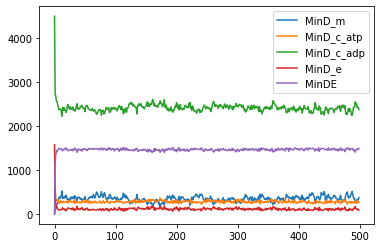

In [6]:
for s in result.model.get_all_species().keys():
    val = result.get_species(s)
    plt.plot(result.model.tspan, np.sum(val,axis=1), '-', label=s)
plt.legend()

In [7]:
model.listOfSpecies

OrderedDict([('MinD_m', <spatialpy.Model.Species at 0x128442640>),
             ('MinD_c_atp', <spatialpy.Model.Species at 0x128442070>),
             ('MinD_c_adp', <spatialpy.Model.Species at 0x128442eb0>),
             ('MinD_e', <spatialpy.Model.Species at 0x128442f10>),
             ('MinDE', <spatialpy.Model.Species at 0x128442100>)])

In [8]:
from spatialpy import Solver
sol = Solver(model, debug_level=0)
%time result = sol.run()

CPU times: user 90.8 ms, sys: 70.4 ms, total: 161 ms
Wall time: 1min 48s


In [9]:
result.read_step(0)

(array([[ 0.0000000e+00, -2.5000000e-07,  0.0000000e+00],
        [ 2.5000000e-07,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  2.2500001e-06,  0.0000000e+00],
        ...,
        [ 1.9701669e-07,  8.3763337e-07,  4.6025651e-08],
        [ 4.8583356e-08,  9.9583565e-07,  1.8205422e-07],
        [ 6.9438968e-08,  1.6400351e-06,  1.7765137e-07]], dtype=float32),
 {'id': array([   0,    1,    2, ..., 1025, 1026, 1027]),
  'type': array([1, 1, 1, ..., 1, 1, 1]),
  'v': array([[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]),
  'rho': array([1., 1., 1., ..., 1., 1., 1.]),
  'mass': array([0., 0., 0., ..., 0., 0., 0.]),
  'bvf_phi': array([0., 0., 0., ..., 0., 0., 0.]),
  'nu': array([0., 0., 0., ..., 0., 0., 0.]),
  'C[MinD_m]': array([0., 0., 0., ..., 0., 0., 0.]),
  'C[MinD_c_atp]': array([0., 0., 0., ..., 0., 0., 0.]),
  'C[MinD_c_adp]': array([7., 8., 3., ..., 4., 5., 5.]),
  'C

In [10]:
model.domain.vertices.shape

(1028, 3)

# Analysis of 'result' object 

Text(0, 0.5, 'Copy number of membrane bound MinD in half of the cell')

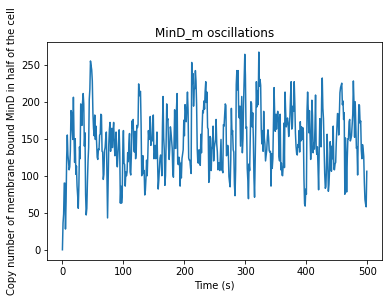

In [11]:
mindm = result.get_species("MinD_m")

y_vals = model.domain.coordinates()[:, 1]
idx = y_vals < 1e-6
mindmsum = np.sum(mindm[:,idx],axis=1)
plt.plot(model.tspan, mindmsum)
plt.title('MinD_m oscillations')
plt.xlabel('Time (s)')
plt.ylabel('Copy number of membrane bound MinD in half of the cell')

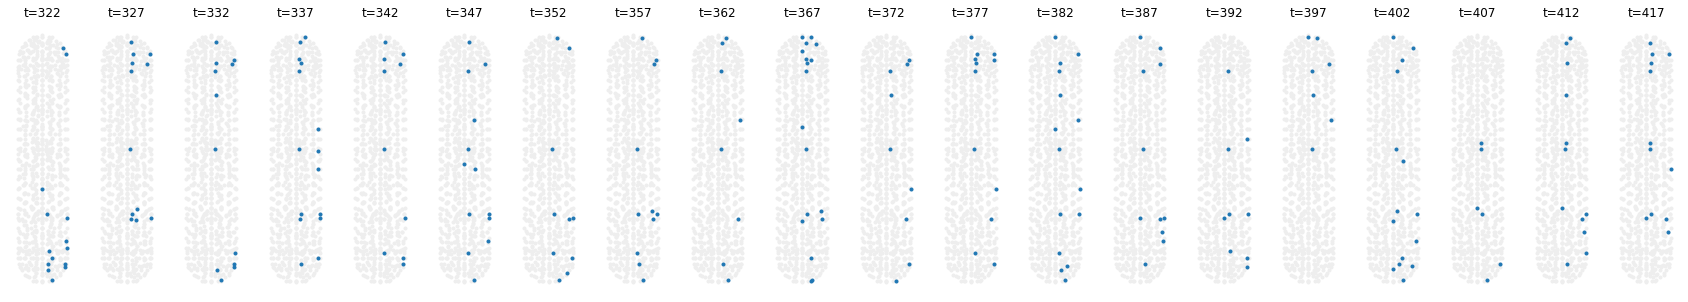

In [12]:
mx = np.max(mindmsum)
tmax = [i for i, j in enumerate(mindmsum) if j == mx][0]
# tlist = range(model.tspan[-1]-100,model.tspan[-1],10)
tlist = range(tmax, tmax+100, 5)
# plt.figure(figsize=(len(tlist)*0.75,2))
plt.figure(figsize=(len(tlist)*1.5, 5))
for num, tnow in enumerate(tlist):
    minD1 = result.get_species("MinD_m", tnow)
    xlist = []
    ylist = []
    zlist = []
    cutoff = 5
    for vndx, minD_val in enumerate(minD1):
        if minD_val > cutoff:
            c = model.domain.coordinates()[vndx,:]
            #print vndx, minD_val, c
            xlist.append(c[0])
            ylist.append(c[1])
            zlist.append(c[2])

    plt.subplot(1,len(tlist),num+1)
    plt.plot(model.domain.coordinates()[:,0], model.domain.coordinates()[:,1], '.', color='#eeeeee')
    plt.plot(xlist,ylist,'.')
    plt.title('t={0}'.format(tnow))
    plt.xlim(-3e-7, 3e-7)
    plt.ylim(-5e-7, 25e-6)
    plt.axis('equal')
    plt.axis('off')


In [13]:
minD1.shape

(1028,)